# Segment Classification

In [1]:
import os.path
import sys
from typing import Tuple

sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from dataset.ki import KIDataset
from einops import rearrange
from einops.layers.torch import Rearrange
from models.classifier import IndividualClassifier
from models.inception import InceptionTimeModel
from utils.data import PadCollate
from utils.misc import set_random_state
from utils.path import checkpoints_path as MODELS_PATH

torch.set_default_dtype(torch.float)
SEED = 42
DEVICE = 'cuda'
INCLUDE_PDON_TF = True
INCLUDE_PDON_SEGM = True
BINARY_CLF = True
N_EPOCHS = 400
N_EPOCHS_CLF = 100
EMBEDDER_CHKPT_FPATH = os.path.join(MODELS_PATH, f'inception_time{"_pdon" if INCLUDE_PDON_SEGM else ""}.pth')
CLF_CHKPT_FPATH = os.path.join(MODELS_PATH, f'linear_clf{"_pdon" if INCLUDE_PDON_SEGM else ""}.pth')
IND_CLF_CHKPT_FPATH = os.path.join(MODELS_PATH, f'ind_clf{"_pdon" if INCLUDE_PDON_SEGM else ""}.pth')
TEST_CLF = False
ANAL_CLF = True
set_random_state(SEED)

## Dataset/Dataloader Initialization

In [2]:
# Initialize Datasets
ds_segm_train = KIDataset(train=True, which='segments', config='ki_auto', ki_data_dirname='KI',
                          data_sources=['HC', 'PD_OFF', 'PD_ON'] if INCLUDE_PDON_SEGM else ['HC', 'PD_OFF'])
ds_segm_test = KIDataset(train=False, which='segments', config='ki_auto', ki_data_dirname='KI',
                         data_sources=['HC', 'PD_OFF', 'PD_ON'])

[KIDataset] datapoint distribution over 480 points:
			PD_OFF: 41.67%
			PD_ON: 40.83%
			HC: 17.50%
[KIDataset] datapoint distribution over 203 points:
			PD_OFF: 64.04%
			PD_ON: 12.81%
			HC: 23.15%


In [3]:
ds_segm_train[0].x.shape, ds_segm_train.columns

(torch.Size([441, 4]), ['position', 'drift', 'position_diff', 'drift_diff'])

In [4]:
class TripletSegmentDataset(Dataset):
    def __init__(self, ds: KIDataset, binary_clf: bool = BINARY_CLF):
        self.ds = ds
        self.binary_clf = binary_clf

    def __process_label(self, lab: torch.Tensor) -> torch.Tensor:
        if self.binary_clf:
            if lab == 2:
                lab = torch.tensor(1, dtype=int)
            return F.one_hot(lab.type(torch.int64), num_classes=2 if self.binary_clf else 3)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor] or Tuple[torch.Tensor, ...]:
        anchor = self.ds[idx]
        if not self.ds.train:
            return anchor.x, self.__process_label(anchor.y)
        
        # Augmentation: add light random noise
        anchor.x += 1e-2 * torch.randn_like(anchor.x)

        positive_indices = (self.ds.y == anchor.y).nonzero()
        positive_indices = positive_indices[positive_indices != idx][:, None]
        negative_indices = (self.ds.y != anchor.y).nonzero()

        positive_idx = torch.randperm(positive_indices.numel())[0]
        negative_idx = torch.randperm(negative_indices.numel())[0]

        positive = self.ds[positive_idx]
        negative = self.ds[negative_idx]

        return anchor.x, self.__process_label(anchor.y), \
            positive.x, self.__process_label(positive.y), \
            negative.x, self.__process_label(negative.y)

    def __len__(self) -> int:
        return self.ds.__len__()


class TripletDataloader(DataLoader):
    def __init__(self, ds: KIDataset, *args, **kwargs):
        triplet_ds = TripletSegmentDataset(ds=ds)
        super().__init__(dataset=triplet_ds, *args, **kwargs)

## InceptionTime Initialization

In [5]:
# Initialize Embedder
embedder = InceptionTimeModel(bottleneck_channels=0,
                              in_channels=4,
                              kernel_sizes=65,
                              num_blocks=3,
                              num_pred_classes=32,
                              out_channels=64,
                              use_residuals='default')
embedder = embedder.to(DEVICE)

# Initialize Classifier
clf = nn.Sequential(
    nn.BatchNorm1d(embedder.out_dim),
    nn.Linear(embedder.out_dim, 10),
    nn.SELU(inplace=True),
    nn.Linear(10, 2),
)
clf = clf.to(DEVICE)

## Training Loop

In [6]:
# Dataloader
dl_segm_train = TripletDataloader(ds_segm_train, batch_size=128, shuffle=True, pin_memory=True)
dl_segm_test = TripletDataloader(ds_segm_test, batch_size=128, shuffle=False, pin_memory=True)

# Optimizers
segm_optim = torch.optim.AdamW(embedder.parameters(), lr=1e-3, weight_decay=1e-2)
segm_optim.add_param_group({
    'params': clf.parameters(),
    'lr': 1e-4,
    'weight_decay': 1e-2
})
segm_optim_sched = torch.optim.lr_scheduler.SequentialLR(
    segm_optim,
    schedulers=[
        torch.optim.lr_scheduler.LinearLR(segm_optim, total_iters=N_EPOCHS // 20),
        torch.optim.lr_scheduler.CosineAnnealingLR(segm_optim, T_max=N_EPOCHS - N_EPOCHS // 20),
    ],
    milestones=[N_EPOCHS // 20]
)

# Criteria
bce_crit = nn.BCEWithLogitsLoss()
triplet_crit = nn.TripletMarginLoss(margin=1.0, p=2, swap=True)

In [7]:
if not os.path.exists(EMBEDDER_CHKPT_FPATH):
    # es = EarlyStopper(patience=10, max_delta_acc=0.05, model=clf, ckpt_path=CHKPT_FPATH)
    pbar = tqdm(range(N_EPOCHS), desc=f'Training InceptionTime')
    lt, lv, at, av = [], [], [], []
    for epoch in pbar:
        # Train
        accs_train, losses_train = [], []
        for ax, ay, px, py, nx, ny in dl_segm_train:
            ax = ax.to(DEVICE)
            ay = ay.to(DEVICE)
            px = px.to(DEVICE)
            py = py.to(DEVICE)
            nx = nx.to(DEVICE)
            ny = ny.to(DEVICE)

            segm_optim.zero_grad()

            # Get embeddings
            ax_feat = embedder(ax.swapaxes(1,2))
            px_feat = embedder(px.swapaxes(1,2))
            nx_feat = embedder(nx.swapaxes(1,2))

            # Get class predictions
            ay_hat = clf(ax_feat)
            py_hat = clf(px_feat)
            ny_hat = clf(nx_feat)

            # Compute losses
            bce_loss = bce_crit(ay_hat, ay.float()) + bce_crit(py_hat, py.float()) + bce_crit(ny_hat, ny.float())
            triplet_loss = triplet_crit(ax_feat, px_feat, nx_feat) + 0.1 * triplet_crit(ay_hat, py_hat, ny_hat)
            total_loss = bce_loss + triplet_loss

            # Update models
            total_loss.backward()
            segm_optim.step()
            losses_train.append(total_loss.item())
            accs_train.append(accuracy_score(ay_hat.detach().cpu().argmax(axis=1), ay.detach().cpu().argmax(axis=1)))

        acc_train_mean = np.mean(accs_train)
        loss_train_mean = np.mean(losses_train)
        segm_optim_sched.step()

        # Eval
        accs_val, losses_val = [], []
        with torch.no_grad():
            embedder.eval()
            clf.eval()
            for x, y in dl_segm_test:
                x = x.to(DEVICE)
                y = y.to(DEVICE)
                y_hat = clf(embedder(x.swapaxes(1,2)))
                losses_val.append(bce_crit(y_hat, y.float()).detach().item())
                accs_val.append(accuracy_score(y_hat.cpu().argmax(axis=1), y.cpu().argmax(axis=1)))
            clf.train()
            embedder.train()
        acc_val_mean = np.mean(accs_val)
        loss_val_mean = np.mean(losses_val)

        pbar.set_description(f'[e|{epoch}][l|t:{loss_train_mean:.2f}, v:{loss_val_mean:.2f}]'
                             f'[acc|t:{acc_train_mean * 100:.2f}, v:{acc_val_mean * 100:.2f}]')

        at.append(acc_train_mean)
        av.append(acc_val_mean)
        lt.append(loss_train_mean)
        lv.append(loss_val_mean)
        # if es.early_stop(acc_val_mean):
        #     break
        # es.revert_chkpt()
    torch.save(embedder, EMBEDDER_CHKPT_FPATH)
    torch.save(clf, CLF_CHKPT_FPATH)

    # Plots
    plt.plot(lt, label='loss train')
    plt.plot(lv, label='loss test')
    plt.legend()
    plt.show()
    plt.plot(at, label='acc train')
    plt.plot(av, label='acc test')
    plt.legend()
    plt.show()
else:
#     embedder = torch.load(EMBEDDER_CHKPT_FPATH).to(DEVICE).eval()
    ...

# Individual Classification

## Datasets Initialization

In [8]:
class IndividualTrialDataset(Dataset):
    def __init__(self, ds: KIDataset, binary_clf: bool = True):
        self.ds = ds
        self.binary_clf = binary_clf

    def __process_label(self, lab: torch.Tensor) -> torch.Tensor:
        if self.binary_clf:
            if lab == 2:
                lab = torch.tensor(1, dtype=int)
            return F.one_hot(lab.type(torch.int64), num_classes=2 if self.binary_clf else 3)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        try:
            trial_data = self.ds[idx]
            return torch.stack([s.x for s in trial_data.x.usable_segments]), self.__process_label(trial_data.y)
        except RuntimeError:
            return self.__getitem__((idx+1) % len(self))

    def __len__(self) -> int:
        return self.ds.__len__()


# Initialize Datasets
ds_trial_train = KIDataset(train=True, which='trials', config='ki_auto', ki_data_dirname='KI',
                          data_sources=['HC', 'PD_OFF', 'PD_ON'] if INCLUDE_PDON_TF else ['HC', 'PD_OFF'])
ds_trial_test = KIDataset(train=False, which='trials', config='ki_auto', ki_data_dirname='KI',
                         data_sources=['HC', 'PD_OFF', 'PD_ON'])

[KIDataset] datapoint distribution over 44 points:
			PD_OFF: 43.18%
			PD_ON: 40.91%
			HC: 15.91%
[KIDataset] datapoint distribution over 19 points:
			PD_OFF: 63.16%
			PD_ON: 15.79%
			HC: 21.05%


## Models Initialization

In [9]:
# Freeze Embedder
embedder_re = nn.Sequential(
    Rearrange('b n l d -> (b n) d l'),
    embedder,
).to(DEVICE).eval()
for p in embedder.parameters():
    p.requires_grad = False

# Weight Initializer
def init_weights(module:nn.Module):
    if isinstance(module, nn.Embedding):
        module.weight.data.normal_(mean=0.0, std=1.0)
        if module.padding_idx is not None:
            module.weight.data[module.padding_idx].zero_()
    elif isinstance(module, nn.LayerNorm):
        module.bias.data.zero_()
        module.weight.data.fill_(1.0)
    elif isinstance(module, nn.Linear):
        module.bias.data.zero_()
        module.weight.data.normal_(mean=0.0, std=0.1)

    
# Initialize Transformer (Classifier)
ind_clf = IndividualClassifier(in_features=32, d_model=128, nhead=4, num_layers=2, dim_feedforward=256,
                           batch_first=True, dropout=0.3, n_classes=2 if BINARY_CLF else 3)
ind_clf.apply(init_weights)
ind_clf = ind_clf.to(DEVICE)

## Training Loop

In [10]:
# Dataloaders
dl_trial_train = DataLoader(IndividualTrialDataset(ds_trial_train), batch_size=16, shuffle=True, pin_memory=True,
                            drop_last=True, collate_fn=PadCollate(dim=0))
dl_trial_test = DataLoader(IndividualTrialDataset(ds_trial_test), batch_size=16, shuffle=False, pin_memory=True,
                            collate_fn=PadCollate(dim=0))

# Optimizers
trial_optim = torch.optim.AdamW(ind_clf.parameters(), lr=1e-5, weight_decay=1e-1)
# segm_optim_sched = torch.optim.lr_scheduler.CosineAnnealingLR(trial_optim, T_max=N_EPOCHS_CLF)
trial_optim_sched = torch.optim.lr_scheduler.SequentialLR(
    trial_optim,
    schedulers=[
        torch.optim.lr_scheduler.LinearLR(trial_optim, total_iters=N_EPOCHS_CLF // 20),
        torch.optim.lr_scheduler.CosineAnnealingLR(trial_optim, T_max=N_EPOCHS_CLF - N_EPOCHS_CLF // 20),
    ],
    milestones=[N_EPOCHS_CLF // 20]
)

# Criteria
bce_crit = nn.BCEWithLogitsLoss()

Training Transformer:   0%|          | 0/100 [00:00<?, ?it/s]/home/achariso/anaconda3/envs/torch3d/lib/python3.9/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
Training Transformer [e|3][l|t:0.72, v:0.95][acc|t:59.38, v:84.38]:   4%|▍         | 4/100 [00:03<01:04,  1.49it/s]/home/achariso/anaconda3/envs/torch3d/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are

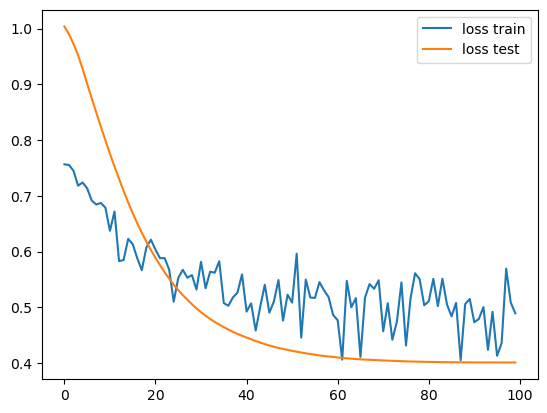

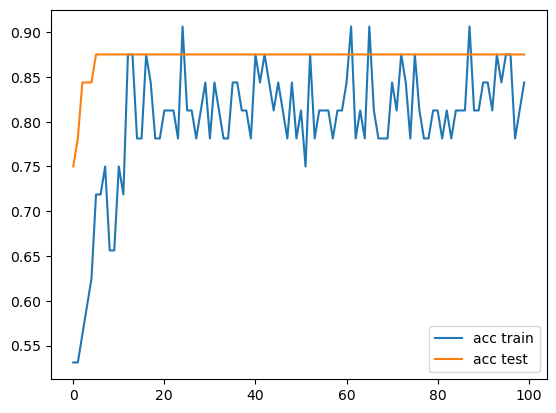

In [11]:
pbar = tqdm(range(N_EPOCHS_CLF), desc=f'Training Transformer')
lt, lv, at, av = [], [], [], []
for epoch in pbar:
    # Train
    accs_train, losses_train = [], []
    for tx, ty in dl_trial_train:
        tx = tx.to(DEVICE)
        ty = ty.to(DEVICE)

        trial_optim.zero_grad()

        # Get embeddings
        with torch.no_grad():
            tx_feat = rearrange(embedder_re(tx), '(b n) d -> b n d', b=tx.shape[0])

        # Get class predictions
        ty_hat = ind_clf(tx_feat)

        # Compute losses
        bce_loss = bce_crit(ty_hat, ty.float())

        # Update model
        bce_loss.backward()
        trial_optim.step()
        losses_train.append(bce_loss.item())
        accs_train.append(accuracy_score(ty_hat.detach().cpu().argmax(axis=1), ty.detach().cpu().argmax(axis=1)))
    
    acc_train_mean = np.mean(accs_train)
    loss_train_mean = np.mean(losses_train)
    trial_optim_sched.step()

    # Eval
    accs_val, losses_val = [], []
    with torch.no_grad():
        ind_clf.eval()
        for x, y in dl_trial_test:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            y_hat = ind_clf(rearrange(embedder_re(x), '(b n) d -> b n d', b=x.shape[0]))
            losses_val.append(bce_crit(y_hat, y.float()).detach().item())
            accs_val.append(accuracy_score(y_hat.cpu().argmax(axis=1), y.cpu().argmax(axis=1)))
        ind_clf.train()
    acc_val_mean = np.mean(accs_val)
    loss_val_mean = np.mean(losses_val)

    pbar.set_description(f'Training Transformer [e|{epoch}][l|t:{loss_train_mean:.2f}, v:{loss_val_mean:.2f}]'
                         f'[acc|t:{acc_train_mean * 100:.2f}, v:{acc_val_mean * 100:.2f}]')

    at.append(acc_train_mean)
    av.append(acc_val_mean)
    lt.append(loss_train_mean)
    lv.append(loss_val_mean)
    # if es.early_stop(acc_val_mean):
    #     break
    # es.revert_chkpt()
torch.save(ind_clf, IND_CLF_CHKPT_FPATH)

# Plots
plt.plot(lt, label='loss train')
plt.plot(lv, label='loss test')
plt.legend()
plt.show()
plt.plot(at, label='acc train')
plt.plot(av, label='acc test')
plt.legend()
plt.show()